# From Idea to Implementation

In this exercise, the goal was to
1. Test whether augmenting Spatial Transformer Networks (STNs) with CoordConv layers can help improve classification performance on MNIST;
2. Motivate the chosen performance metrics;
3. Implement another idea to see whether it can improve performance compared to the aforementioned models.

## 0. STN vs CNN

Although it was not strictly a part of this task, I was interested in measuring how great of a performance boost using a STN
provides over using just the Convolutional Neural Network (CNN) that is part of the [baseline implementation](https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html).
Since measuring the difference came at no great extra cost (adding an `if` statement and another model to the model list), I also included the performance of CNN for comparison.

## 1. STN(alias Baseline) vs CoordConvSTN (vs CoordConv)

We wish to see whether replacing the Conv2d layers in the Baseline model with CoordConv layers boosts classification performance.
To do this, I found the [reference CoordConv implementation as a TensorFlow/Keras layer](https://github.com/uber-research/CoordConv/blob/master/CoordConv.py) and implemented a version of it in PyTorch.
I would have used someone else's implementation, but didn't find one that was either popular or didn't have some open Issues.
Moreover, since the idea was simple, I wanted to test whether I understood how CoordConv works.
To test the accuracy of the implementation, I fed an RGB image of 0s to both layers and tested the difference in the outputs up to a certain tolerance.
This is necessary as the modules may use different default precision or floating point datatypes.

Also, I couldn't resist adding another model to the comparison: CoordConv without STN.
Similarly to 0., it came at no great extra cost. However, if this were a severely time- and resource-constrained task I would not have engaged in this extra experimentation (e.g. this task is a blocker for someone else's work).

## 2. Performance Metrics

Without additional context, the fraction of correctly classified digits seems like a reasonable performance metric.
However, if there were different business-related costs to misclassifying certain digits (e.g. certain numbers occur more frequently in some applications), then I also saved the
Confusion Matrix for each evaluation. When business requirements change, then we can evaluate which model could be an improved fit without re-training all models.

## 3. Inverse-Compositional Spatial Transformer Networks

In this experiment, I experimented with a few ideas from the paper ["Inverse Compositional Spatial Transformer Networks"](https://arxiv.org/abs/1612.03897),
[corresponding GitHub repository](https://github.com/chenhsuanlin/inverse-compositional-STN).
Key takeaways:
* Instead of using an affine transformation (6 learnable parameters), I used a homography (8 learnable parameters). A [short and sweet explanation](https://stackoverflow.com/questions/45637472/opencv-transformationmatrix-affine-vs-perspective-warping) and the source code of [`vec2mtrx`](https://github.com/chenhsuanlin/inverse-compositional-STN/blob/master/MNIST-pytorch/warp.py#L35) helped me understand that a homography is a less constrained/more powerful transformation.
* To use homography, I simplified some key functions from the provided reference implementation (`compose`, `vec2mtrx`, `mtrx2vec`, `transformImage` from [this file](https://github.com/chenhsuanlin/inverse-compositional-STN/blob/master/MNIST-pytorch/warp.py)) to work with the PyTorch models.
* In addition, I tried increasing the number of iterations in a cascading STN (the edge case of 1 iteration is just the regular STN). The authors propose propagating the transformation parameters through multiple loops without actually transforming the image as a method for avoiding some boundary conditions in networks with many non-parallel STNs.
* I purposefully didn't perturb training data with noise as described in the paper. If I start perturbing the training images for one model, then I must start doing it for all other models to have an apples to apples comparison. Moreover, I prefer the idea of having fewer but easier to understand changes to the model as Deep Neural Networks are hard enough to grok as they are :- )

## Model List

name|description|transformation
---|---|---
CNN| CNN | None
Baseline| CNN + STN | affine transformation
CoordConv| CNN w/ CoordConv layers | affine transformation
CoordConvSTN| CNN w/ CoordConv layers + STN | affine transformation
NetHomographic| CNN + STN w/ Homography, 1 iteration | homography
NetHomographic4| CNN + STN w/ Homography, 4 iterations | homography

## Training Parameters

```python
    epochs = 50
    lr = 0.01
    # lr scheduling
    gamma = 0.8
    step_size = 10
    n_seeds = 30
    for seed, (model_name, model_fn) in product(range(n_seeds), model_list):
        # same neural network weights
        torch.random.manual_seed(seed)

        model = model_fn().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('results.csv')
for col in ['test_losses', 'n_corrects', 'cms']:
    df[col] = df[col].apply(lambda x: np.array(eval(x), dtype=float))
    df[f'last_{col}'] = df[col].apply(lambda x: x[-1])
    if col == 'test_losses':
        df[f'best_{col}'] = df[col].apply(np.min)
        df[f'best_{col}_idx'] = df[col].apply(np.argmin)
    elif col == 'n_corrects':
        df[f'best_{col}'] = df[col].apply(np.max)
        df[f'best_{col}_idx'] = df[col].apply(np.argmax)
    elif col == 'cms':
        df[f'best_{col}'] = df[col].apply(lambda x: x[np.argmax([np.sum(y*np.eye(10)) for y in x])])

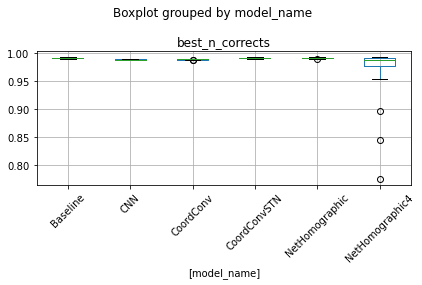

In [3]:
df[['model_name', 'best_n_corrects']].boxplot(by='model_name', rot=45)
plt.tight_layout()

Since NetHomographic4's performance severely distorts the plot, lets remove it for now.

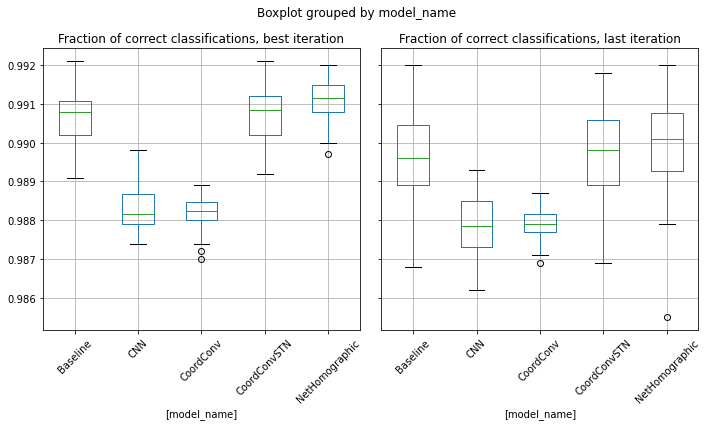

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(10, 6)

data = df.loc[df['model_name'] != 'NetHomographic4', ['model_name', 'best_n_corrects']]
models = data['model_name'].unique()
medians = [data.loc[data['model_name'] == m, 'best_n_corrects'].median() for m in models]
data.boxplot(by='model_name', rot=45, ax=ax[0])
ax[0].set_title('Fraction of correct classifications, best iteration, n=30')

data = df.loc[df['model_name'] != 'NetHomographic4', ['model_name', 'last_n_corrects']]
models = data['model_name'].unique()
data.boxplot(by='model_name', rot=45, ax=ax[1])
ax[1].set_title('Fraction of correct classifications, last iteration, n=30')
plt.tight_layout()

Comparing both the best model iteration and the last model iteration we can approximately estimate how stable the training process is.
The ranking of the models stays the same, indicating that none of the models have diverged by the end of training.
Of course, the range of performance is wider when looking only at the last iteration.

Curiously, CNN seems to have better best-case performance than using CoordConv! A possible explanation for this may be the fact that I based my CoordConv implementation on the TensorFlow reference implementation.
When working with pretrained ImageNet models in TensorFlow vs PyTorch, you should always be aware of how the input data is processed: in PyTorch, the pixel values in an image get converted to [0, 1], but in TensorFlow it can be [-1, 1] instead! [see this for example](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input)
However, CoordConvSTN performs better than either of the two models, so the true cause is unclear.

Interestingly, using a homography instead of an affine transformation leads to better performance compared to other models, barring an outlier.
This may be due to the more flexible image transformation at our disposal. Perhaps a similar improvement could be seen when using Thin Plated Splines (TPS) as used in the original STN paper.

NetHomographic4's poor performance is unclear.
A difference from the original paper is the intialisation: in all tested models, I used the default (random uniform) initialisation. However, the authors drew the initial weights from $$ \mathcal{N}(0, 0.1)$$.
[It is known that a good initialisation can make a network learn better](https://arxiv.org/abs/1511.06422).
The difference in initialisation strategy may be one cause for the poor performance.

Another potential cause is the difference in learning rate.
The original paper used constant learning rates of $10^{-4}$ for the STN network and $10^{-2}$ for the classification network.
However, my experiment started with $10^{-2}$ and reduced it throughout raining.
This is empirical evidence that the other tested networks are more resilient against larger changes in the network.

## Limitations
* Only 30 random seeds, barely covers any space in the Neural Network Parameter space
  * However, I am mortal and without infinite computational resources :- )
* Learning task may be too simple to observe the true extent of improvements of the more advanced techniques like STN, STN + Homography, CoordConv
* Would be nice to test that models will run and train for 1 epoch before the true training starts

## Future Work
Some ideas for future experiments:
* Different learning rates for the STN network and prediction network like in the Inverse-Compositional STN paper
* Different initialisations e.g. $$ \mathcal{N}(0, 0.1) $$
* Add L2 regularisation
* A smarter optimiser e.g. Adam
